<a href="https://colab.research.google.com/github/WoogiWooks/Kaggle_ML/blob/main/%EB%B6%84%EB%A5%98_%EC%B9%B4%EB%93%9C_%EC%82%AC%EA%B8%B0_%EA%B2%80%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/캐글/완벽가이드 예제

/content/drive/MyDrive/캐글/완벽가이드 예제


In [2]:
from score import *

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

In [47]:
import sklearn
import lightgbm
print(lightgbm.__version__)
print(sklearn.__version__)

2.2.3
1.0.2


In [5]:
Data = pd.read_csv("/content/drive/MyDrive/캐글/완벽가이드 예제/4장. 분류/Credit Card Fraud Detection/creditcard.csv")

In [6]:
Data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [7]:
print(Data["Class"].value_counts())
Negative = Data["Class"].value_counts()[0]
Positive = Data["Class"].value_counts()[1]
N_ratio = Negative/(Negative+Positive)
P_ratio = Positive/(Negative+Positive)
print(N_ratio*100)
print(P_ratio*100)

# 레이블 값이 매우 불균형함
# 학습 과정에서 정상 레이블에 치우친 학습이 일어나게 됨
# 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 적지만 중요한 이슈

0    284315
1       492
Name: Class, dtype: int64
99.82725143693798
0.1727485630620034


## **언더 샘플링**
* 많은 데이터 세트를 적은 숫자로 바꾸는 것
  * 10,000건의 정상 데이터와 100건의 이상 데이터가 있을 때, 정상 레이블 데이터를 100건으로 줄여버림
* 데이터 건수가 줄어들어 오히려 학습이 잘 되지 않을 수 있어 잘 사용하지 않음

## **오버 샘플링**
* 적은 데이터 세트를 증식함
* 동일 데이터를 단순 증식하는 방법은 과적합 문제가 발생 가능
  * 원본 데이터의 피처값들을 약간씩 변경하여 증식
* SMOTE : 대표적인 오버 샘플링 방법
  * 적은 데이터 세트에 있는 데이터들의 K-Nearest Neighbor 를 찾아 데이터와 이웃 데이터를 통해 새로운 데이터 생성

In [8]:
!pip install imbalanced-learn

# **데이터 가공 전 모델 구축**

In [9]:
Data.info()

# 필요없는 Time 피쳐 삭제

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop("Time", axis=1, inplace=True)
  return df_copy

In [11]:
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df(df)
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, stratify=y_target, random_state=100)
  return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = get_train_test_dataset(Data)

In [13]:
print("학습데이터 레이블 비율")
print(y_train.value_counts()/y_train.shape[0]*100)
print("테스트데이터 레이블 비율")
print(y_test.value_counts()/y_test.shape[0]*100)

학습데이터 레이블 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트데이터 레이블 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [14]:
# 데이터 가공 전 모델 성능
# LogisticRegression 사용

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

classify_score(y_test, lr_pred, lr_pred_proba)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


정확도: 0.9991
정밀도: 0.7951
재현율: 0.6554
F1: 0.7185
ROC: 0.9534


In [20]:
# 데이터 가공 전 모델 성능
# LightGBM 사용
# 모델에 따른 학습 함수 생성

def get_model_train_eval(model, X_train=None, X_test=None, y_train=None, y_test=None):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  pred_proba = model.predict_proba(X_test)[:, 1]
  classify_score(y_test, pred, pred_proba)

############ LightGBM 에서 레이블이 불균형한 데이터 학습시 boost_from_average=False 로 파라미터 설정 필요 ###############

from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

정확도: 0.9996
정밀도: 0.9444
재현율: 0.8041
F1: 0.8686
ROC: 0.9746


# **데이터 분포도 변환 후 모델 평가**



## **1. StandardScaler 적용**
  * 선형 모델은 피쳐 내 데이터 값이 "***정규 분포***" 를 띄는 것이 좋음
  * RBF_SVM, 선형회귀, 로지스틱 회귀 같은 선형 모델은 데이터가 가우시안 분포를 가지고 있다 가정하므로 표준화 중요
  * 중요 피쳐에 대하여 정규화 적용

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


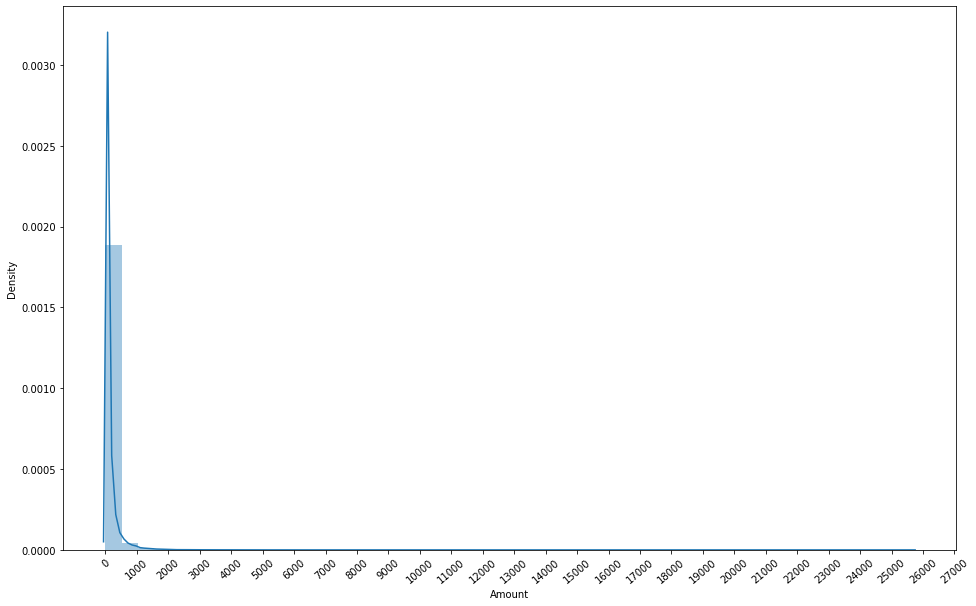

In [30]:
# 중요 피쳐의 데이터 분포 확인

import seaborn as sns
plt.figure(figsize=(16, 10))
plt.xticks(range(0, 30000, 1000), rotation=40)
sns.distplot(Data["Amount"])

In [21]:
# 중요 피쳐에 대하여 표준화 적용

from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  Amount_stnd = scaler.fit_transform(df_copy["Amount"].values.reshape(-1, 1))     # 피쳐 하나만 표준화 할때는, Series로 받으므로 values.reshape 한 뒤 표준화 적용해야 함
  df_copy["Amount"] = Amount_stnd
  df_copy.drop("Time", axis=1, inplace=True)
  return df_copy

In [22]:
X_train, X_test, y_train, y_test = get_train_test_dataset(Data)

In [23]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

정확도: 0.9991
정밀도: 0.8241
재현율: 0.6014
F1: 0.6953
ROC: 0.9665


In [24]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

# 표준화 적용에도 성능 변화가 없음

정확도: 0.9996
정밀도: 0.9365
재현율: 0.7973
F1: 0.8613
ROC: 0.9714


## **2. 로그 변환 적용**
  * 데이터 ***분포도가 심하게 왜곡되어 있을 경우*** 적용하는 중요 기법
  * Numpy 의 log1p 함수를 사용


In [25]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  Amount_log = np.log1p(df_copy["Amount"].values.reshape(-1,1))
  df_copy["Amount"] = Amount_log
  df_copy.drop("Time", axis=1, inplace=True)
  return df_copy

In [26]:
X_train, X_test, y_train, y_test = get_train_test_dataset(Data)

In [27]:
# lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

정확도: 0.9991
정밀도: 0.8241
재현율: 0.6014
F1: 0.6953
ROC: 0.9665


In [29]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

# 약간의 재현율 개선!!

정확도: 0.9996
정밀도: 0.9444
재현율: 0.8041
F1: 0.8686
ROC: 0.9746


# **이상치 데이터 제거 후 모델 평가**

## **1. IQR 방식**
  * 사분위수의 Q3-Q1 = IQR
  * 최댓값 = Q3 + (IQR x 1.5) => 1.5 는 경우에 따라 조절되어 변경 가능
  * 최소값 = Q1 - (IQR x 1.5) => 1.5 는 경우에 따라 조절되어 변경 가능
  * 최대, 최소 벗어나는 값들은 이상치로 간주
  * 피쳐가 많을 경우, "***레이블값과 가장 상관성이 높은 피처들***" 을 위주로 이상치 검출하는 것이 좋음

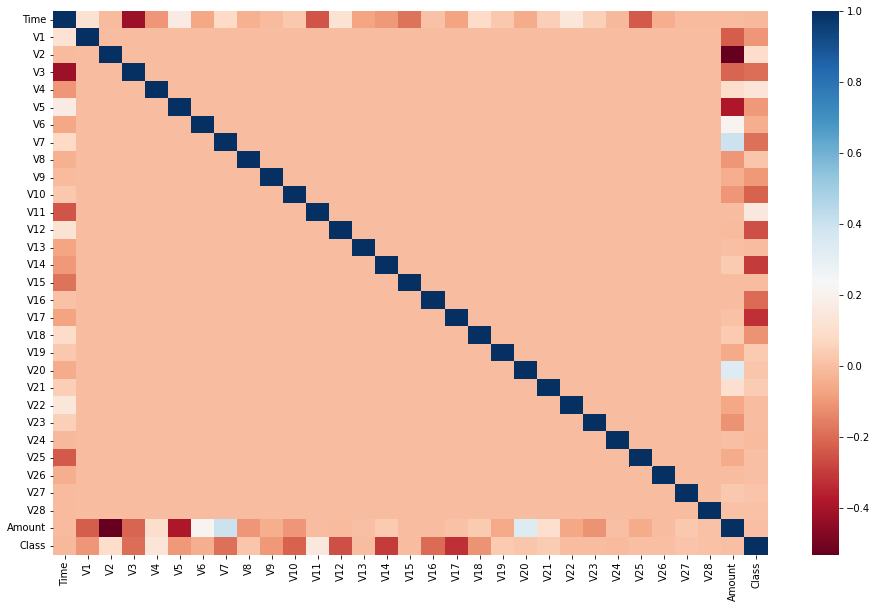

In [51]:
# 상관성 검정

plt.figure(figsize=(16,10))
corr = Data.corr()
sns.heatmap(corr, cmap="RdBu")

# V14, V17 피쳐가 높은 음의 상관관계 보임

In [36]:
# 정상(0)과 사기(1) 모두에 대해 IQR 설정하면 삭제 범위가 너무 커져서 모델 학습에 영향 미침
# 해당 문제에서 중요한 것은 실제 사기를 잘 예측하는 것이 중요하므로 사기에 대하여 영향 미치는 아웃라이어를 제거하는 것이 필요

def get_outlier(df=None, column=None, weight=1.5):
  fraud = df[df["Class"]==1][column]  # 위에서 언급한 부분
  Q1 = np.percentile(fraud.values, 25)
  Q3 = np.percentile(fraud.values, 75)
  IQR = Q3-Q1
  lowest = Q1-weight*IQR
  highest = Q3+weight*IQR
  outlier = fraud[(fraud<lowest) | (fraud>highest)].index
  return outlier

In [83]:
# 전체 데이터에 대해서 이상치 제거
# 위에 것과 따로 돌리면서 성능이 어떻게 다른지 비교

def get_outlier(df=None, column=None, weight=1.5):
  fraud = df[column]
  Q1 = np.percentile(fraud.values, 25)
  Q3 = np.percentile(fraud.values, 75)
  IQR = Q3-Q1
  lowest = Q1-weight*IQR
  highest = Q3+weight*IQR
  outlier = fraud[fraud<lowest].index | fraud[fraud>highest].index
  return outlier

In [37]:
outlier14 = get_outlier(Data, "V14", 1.5)
outlier17 = get_outlier(Data, "V17", 1.5)
print(outlier14)
print(outlier17)

Int64Index([8296, 8615, 9035, 9252], dtype='int64')
Int64Index([], dtype='int64')


In [38]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  Amount_log = np.log1p(df_copy["Amount"].values.reshape(-1,1))
  df_copy["Amount"] = Amount_log
  df_copy.drop("Time", axis=1, inplace=True)
  outlier = get_outlier(df_copy, "V14", 1.5)
  df_copy.drop(outlier, axis=0, inplace=True)
  return df_copy

In [39]:
X_train, X_test, y_train, y_test = get_train_test_dataset(Data)

In [34]:
# lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

정확도: 0.9990
정밀도: 0.7778
재현율: 0.5753
F1: 0.6614
ROC: 0.9715


In [40]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

# 재현율이 약간 떨어졌는데 이유를 모르겠음...ㅠㅠ

정확도: 0.9995
정밀도: 0.9280
재현율: 0.7945
F1: 0.8561
ROC: 0.9749


# **SMOTE 통한 오버샘플링 후 모델 평가**
* 반드시 **"학습 데이터 세트에 대해서만"** 오버샘플링 적용해야!!!
* SMOTE를 적용하면 일반적으로 재현율은 높아지나, 정밀도는 낮아짐

In [52]:
import imblearn
print(imblearn.__version__)

0.8.1


In [41]:
X_train, X_test, y_train, y_test = get_train_test_dataset(Data)

In [42]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 전", X_train.shape, y_train.shape)
print("SMOTE 후", X_train_over.shape, y_train_over.shape)
print("SMOTE 후 레이블 분포 \n", y_train_over.value_counts())

SMOTE 전 (199362, 29) (199362,)
SMOTE 후 (398040, 29) (398040,)
SMOTE 후 레이블 분포 
 1    199020
0    199020
Name: Class, dtype: int64


In [107]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

# 너무 많은 사기 데이터를 학습하면서 오히려 정밀도가 급감

정확도: 0.9767
정밀도: 0.0610
재현율: 0.8767
F1: 0.1141
ROC: 0.9746


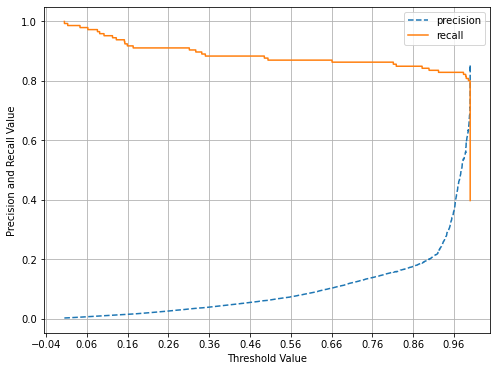

In [109]:
pr_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

# 임계값을 조절하더라도 민감도가 너무 심해 LogisticRegression 에서는 올바른 정밀/재현율 성능을 얻을 수 없음

In [48]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=True)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

정확도: 0.9323
정밀도: 0.0217
재현율: 0.8767
F1: 0.0424
ROC: 0.9045


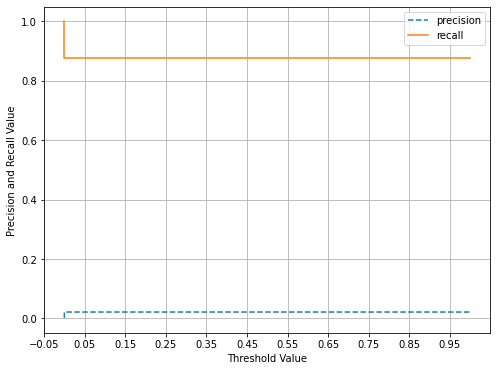

In [113]:
pr_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:, 1])